## **Prior Functions**

In [1]:
def get_data(url, drop=[]):
    import pandas as pd
    df = pd.read_csv(url)
    if len(drop) > 0:
        for col in drop:
            df.drop(columns=[col], inplace=True)
    return df


def bin_groups(df, percent=.05):
    import pandas as pd
    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            for group, count in df[col].value_counts().iteritems():
                if count / len(df) < percent:
                    df.loc[df[col] == group, col] = 'Other'
    return df


def drop_columns_missing_data(df, cutoff=.5):
    import pandas as pd
    for col in df:
        if df[col].isna().sum() / len(df) > cutoff:
            df.drop(columns=[col], inplace=True)
    return df


def impute_mean(df):
    from sklearn.impute import SimpleImputer
    import pandas as pd
    import numpy as np
    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df = pd.get_dummies(df, columns=[col], drop_first=True)
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
    return df


def impute_KNN(df):
    from sklearn.impute import KNNImputer
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df = pd.get_dummies(df, columns=[col], drop_first=True)
    df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
    imp = KNNImputer(n_neighbors=5, weights="uniform")
    df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
    return df


def impute_reg(df):
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    import pandas as pd
    for col in df:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df = pd.get_dummies(df, columns=[col], drop_first=True)
    imp = IterativeImputer(max_iter=10, random_state=12345)
    df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)
    return df


def fit_mlr(df, test_size=.2, random_state=12345, label=''):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    import pandas as pd
    X = df.drop(label, axis=1)
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state)
    model = LinearRegression().fit(X_train, y_train)
    print(f'R-squared (mlr): \t{model.score(X_test, y_test)}')
    return model


def fit_crossvalidate_mlr(df, k, label, repeat=True):
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
    import pandas as pd
    from numpy import mean, std
    X = df.drop(label, axis=1)
    y = df[label]
    if repeat:
        cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=12345)
    else:
        cv = KFold(n_splits=10, random_state=12345, shuffle=True)
    scores = cross_val_score(LinearRegression(), X, y,
                             scoring='r2', cv=cv, n_jobs=-1)
    print(f'Average R-squared:\t{mean(scores)}')
    return LinearRegression().fit(X, y)


# **Feature Importance**

In [2]:
#Data cleaning and preperation pipeline
df = get_data('http://www.ishelp.info/data/housing_full.csv', ['Id'])
df = bin_groups(df)
df = drop_columns_missing_data(df, cutoff=.45)
df = impute_mean(df)

#Modeling pipeline
    #use 5 instead of 10 for the Final Project
model = fit_crossvalidate_mlr(df, 10, label='SalePrice')

#Deployment pipeline

Average R-squared:	0.797855361810675


### **Simple bivariate feature importance**

Pearson correlation, t-test, or chi square

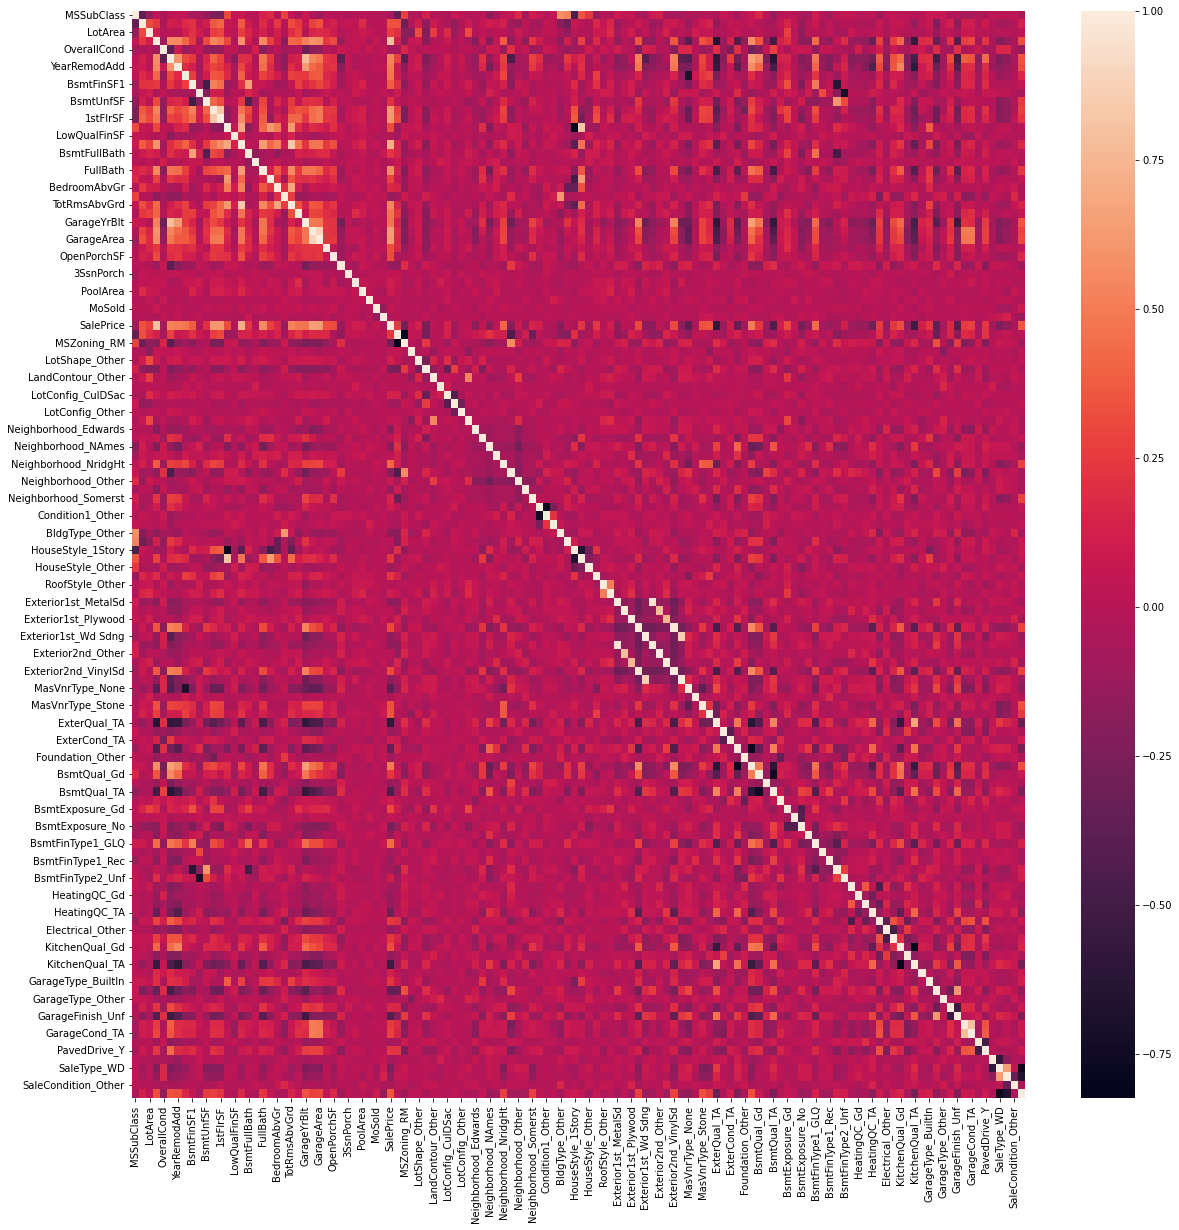

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20, 20))
sns.heatmap(df.corr())
plt.show()

### **Multivariate feature importance**

Linear Model: Coefficients

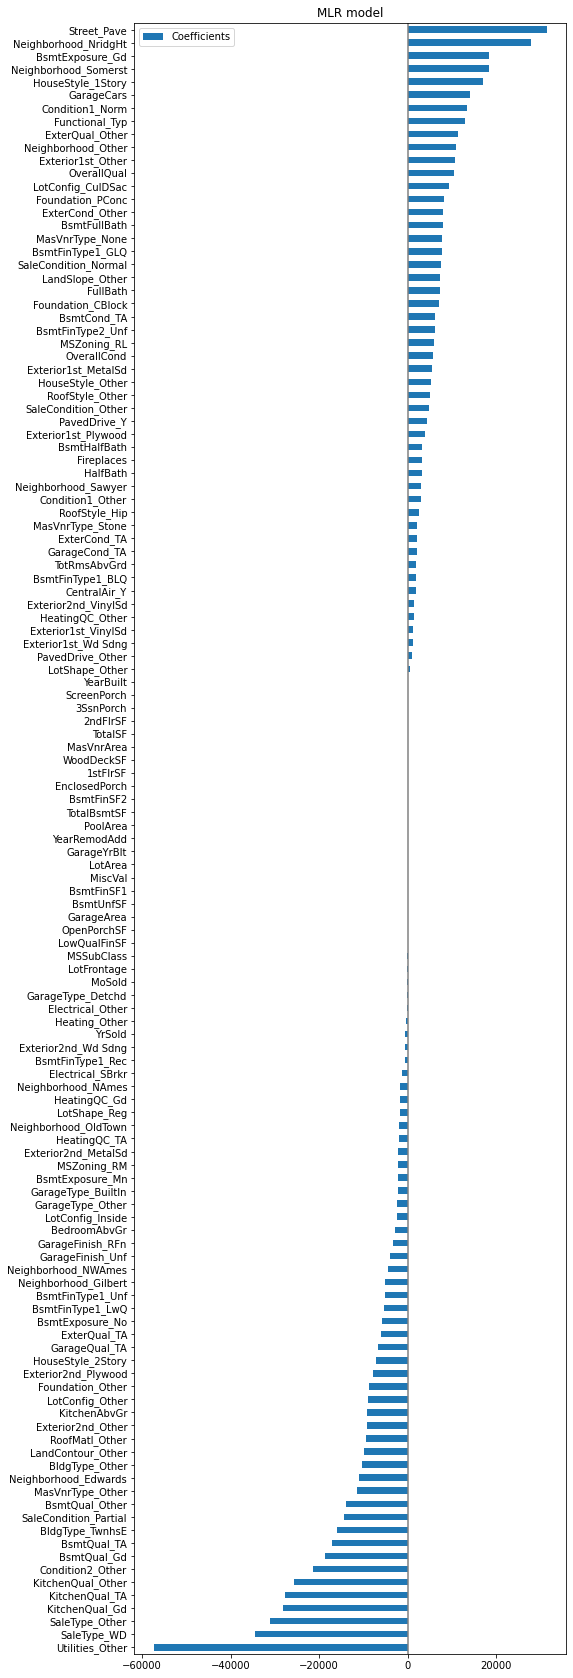

In [4]:
#This cell runs an unstandardized linear regression model on the data. It is not useful because all coefficients
#are on a different scale. See next code block

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=df.drop(columns=['SalePrice']).columns
)

coefs.sort_values(by=['Coefficients'], inplace=True)

coefs.plot(kind='barh', figsize=(10, 30))
plt.title('MLR model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Average R-squared:	-1.996278742354764e+17


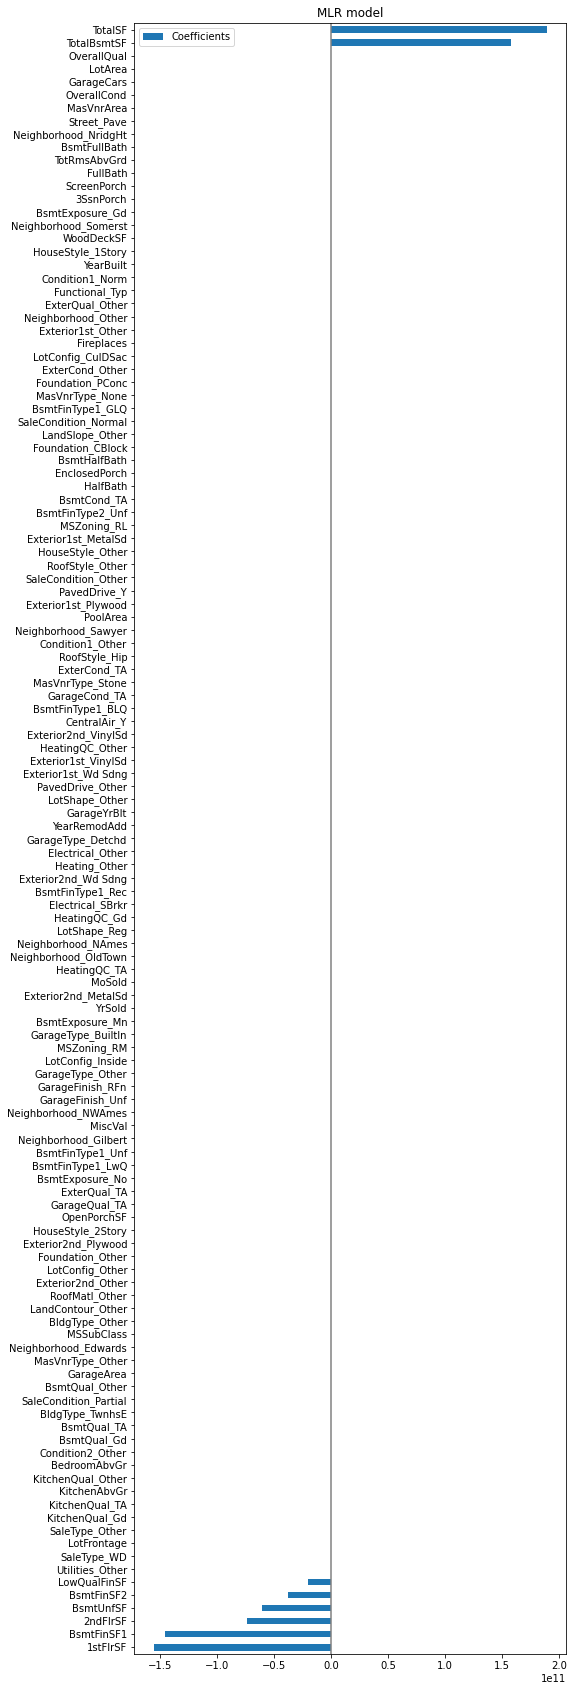

In [5]:
#Still has issues with multicollineiarity. See Vif (next block) for why

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

# Standardize the data to compare feature importances
df_minmax = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(df), columns=df.columns)

# Run our fit_crossvalidate_mlr function to get back a trained model
model = fit_crossvalidate_mlr(df_minmax, 10, label='SalePrice')

coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=df_minmax.drop(columns=['SalePrice']).columns
)

coefs.sort_values(by=['Coefficients'], inplace=True)

coefs.plot(kind='barh', figsize=(10, 30))
plt.title('MLR model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

# Baseline R2: 0.7975108601968853

In [6]:
#Vif (<10 is good, <5 is great, <3 is best)
#Too much multicollinearity. Tells us that using coefficients won't work for this data

def vif(df, label=""):
  import pandas as pd
  from sklearn.linear_model import LinearRegression
  
  # initialize dictionaries
  vif_dict, tolerance_dict = {}, {}

  # drop unnecessary columns if they are found in the dataframe
  if label in df.columns: df.drop(columns=[label], inplace=True)
  if 'const' in df.columns: df.drop(columns=['const'], inplace=True)

  # form input data for each exogenous variable
  for col in df:
    y = df[col]
    X = df.drop(columns=[col])
    
    # extract r-squared from the fit
    r_squared = LinearRegression().fit(X, y).score(X, y)

    # calculate VIF
    if r_squared < 1: # Prevent division by zero runtime error
      vif = 1/(1 - r_squared) 
    else:
      vif = 100
    vif_dict[col] = vif

    # calculate tolerance
    tolerance = 1 - r_squared
    tolerance_dict[col] = tolerance

  # generate the DataFrame to return
  return pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict}).sort_values(by=['VIF'], ascending=False)

vif(df_minmax).head(20)

,VIF,Tolerance
TotalSF,100.000000,0.000000
BsmtFinSF1,100.000000,0.000000
BsmtFinSF2,100.000000,0.000000
BsmtUnfSF,100.000000,0.000000
TotalBsmtSF,100.000000,0.000000
1stFlrSF,100.000000,0.000000
2ndFlrSF,100.000000,0.000000
LowQualFinSF,100.000000,0.000000
SaleType_WD,62.783505,0.015928
SaleCondition_Partial,42.702099,0.023418


Tree Model: Permutation Feature Importance

In [7]:
# Multivariate feature importance for tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from numpy import mean

y = df.SalePrice
X = df.drop(columns=['SalePrice'])

model = DecisionTreeRegressor()
model.fit(X, y)

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=12345)
scores = cross_val_score(DecisionTreeRegressor(), X, y, scoring='r2', cv=cv, n_jobs=-1)
print(f'Decision Tree R-squared:\t{mean(scores)}')

# Baseline R2:      0.7975108601968853

Decision Tree R-squared:	0.7199968006520869


In [8]:
df_fi = pd.DataFrame({"Feature Importance":model.feature_importances_}, index=df.drop(columns=['SalePrice']).columns)
df_fi.sort_values(by=['Feature Importance'], ascending=False).head()

,Feature Importance
OverallQual,0.635694
TotalSF,0.102043
2ndFlrSF,0.037570
TotalBsmtSF,0.032758
GarageCars,0.023530


In [9]:
import matplotlib, pandas as pd
model.feature_importances_

matplotlib.rc('figure', figsize=[5,5])
plt.style.use('ggplot')

feat_importances = pd.Series(model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')

plt.show()

NameError: name 'X_test' is not defined

# **Feature Selection**: The following are the most common feature selection methods. Choose the one that is most appropriate for your data.

## **Univariate Techniques**
These techniques are simple and quick; potentially useful when there are an extremely high number of features and the most impactful features changes over time.

### **Variance Threshold**
Remove features with variance explained below threshold n

In [ ]:
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# Import data and follow prior cleaning steps
df = get_data('http://www.ishelp.info/data/housing_full.csv', drop=['Id'])
df = bin_groups(df)
df = drop_columns_missing_data(df, cutoff=.45)
df = impute_mean(df)

# Select features only
X = df.drop(columns=['SalePrice'])

# View the total number of features before reducing
print(X.shape)

# Calculate variance based on desired p-value so that Variance = p(1 - p)
# The code below uses p = 0.8 as the cutoff value:
p = .8
sel = VarianceThreshold(threshold=(p * (1 - p)))
sel.fit_transform(X)
X_reduced = pd.DataFrame(sel.fit_transform(X))

# View the remaining number of features
print(X_reduced.shape)

# Notice that columns are dropped
X_reduced.columns

(1460, 125)
(1460, 57)


RangeIndex(start=0, stop=57, step=1)

In [25]:
# To see which columns were retained:
sel.get_feature_names_out()
df[sel.get_feature_names_out()].columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'TotalSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_RL',
       'LotShape_Reg', 'LotConfig_Inside', 'Neighborhood_Other',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'MasVnrType_None', 'ExterQual_TA',
       'Foundation_CBlock', 'Foundation_PConc', 'BsmtQual_Gd', 'BsmtQual_TA',
       'BsmtExposure_No', 'BsmtFinType1_GLQ', 'BsmtFinType1_Unf',
       'HeatingQC_TA', 'KitchenQual_Gd', 'KitchenQual_TA', 'GarageType_Detchd',
       'GarageFinish_RFn', 'GarageFinish_Unf

In [14]:
#THIS IS THE FINALLY WORKING CELL. RUN THIS ONE TO USE THE FULL PIPELINE

def fs_variance(df, label="", p=0.8):
  from sklearn.feature_selection import VarianceThreshold
  import pandas as pd

  if label != "":
    X = df.drop(columns=[label])
    
  sel = VarianceThreshold(threshold=(p * (1 - p)))
  sel.fit_transform(X)

  # Add the label back in after removing poor features
  return df[sel.get_feature_names_out()].join(df[label])


# Integrate this new function into the pipeline:
df = get_data('http://www.ishelp.info/data/housing_full.csv', ['Id'])
df = bin_groups(df)
df = drop_columns_missing_data(df)
df = impute_mean(df)
df = fs_variance(df, label="SalePrice", p=.1)
model = fit_crossvalidate_mlr(df, 10, label="SalePrice")

# MLR all features R2: 0.7975108601968853

Average R-squared:	0.794783554513668


### **SelectKBest**
Select the top k features based on chosen bivariate metric: R2 or Chi2

In [1]:
def fs_selectkbest(df, k=10, label=""):
  from sklearn.feature_selection import SelectKBest, r_regression
  import pandas as pd

  X = df.drop(columns=[label])
  y = df[label]

  # Select the top k features based on a given bivariate metric
  sel = SelectKBest(r_regression, k=k)
  sel.fit_transform(X, y)
  
  return df[sel.get_feature_names_out()].join(df[label])

# Integrate this new function into the pipeline:
df = get_data('http://www.ishelp.info/data/housing_full.csv', ['Id'])
df = bin_groups(df)
df = drop_columns_missing_data(df)
df = impute_mean(df)
df = fs_selectkbest(df, 58, label="SalePrice")
model = fit_crossvalidate_mlr(df, 10, "SalePrice")

# MLR all features R2:  0.7975108601968853
# - Variance Model R2: 0.7891806836088955
# - SelectKBest R2: 0.7816135597350676

NameError: name 'get_data' is not defined

## **Recursive Feature Selection**
Remove the worst feature, then rerun effect size metrics, repeat. This technique is slower, but much more accurate. Use these techniques if you have either adequate processing time or power.

### **L1-based feature selection**

In [19]:
def fs_select_linear(df, label=""):
  from sklearn.svm import LinearSVC
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X = df.drop(label,axis=1)
  y = df[label]

  # As C increases, more features are kept
  lsvc = LinearSVC(C=0.05, penalty="l1", dual=False).fit(X, y)
  sel = SelectFromModel(lsvc, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]

# Integrate this new function into the pipeline:
df = get_data('http://www.ishelp.info/data/housing_full.csv', ['Id'])
df = bin_groups(df)
df = drop_columns_missing_data(df)
df = impute_mean(df)
df = fs_select_linear(df, label="SalePrice")
model = fit_crossvalidate_mlr(df, 10, "SalePrice")

# MLR all features R2:  0.7975108601968853
# - low variance feats: 0.7891806836088955
# Keep 58 best feats:   0.7816135597350667

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Average R-squared:	0.7637683060167688


### **Tree-based feature selection**

In [20]:
def fs_select_trees(df, label="SalePrice"):
  from sklearn.ensemble import ExtraTreesClassifier
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X = df.drop(columns=[label])
  y = df[label]

  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  sel = SelectFromModel(clf, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]

# Integrate this new function into the pipeline:
df = get_data('http://www.ishelp.info/data/housing_full.csv', ['Id'])
df = bin_groups(df)
df = drop_columns_missing_data(df)
df = impute_mean(df)
df = fs_select_trees(df, label="SalePrice")
model = fit_crossvalidate_mlr(df, 10, "SalePrice")

# MLR all features R2:      0.7975108601968853
# - low variance feats:     0.7891806836088955
# Keep 58 best feats:       0.7816135597350667
# L1 recursive selection:   0.7637683060167728

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Average R-squared:	0.7812120007532886


In [ ]:
# MLR all features R2:      0.7975108601968853
# Variance:                 0.7891806836088955
# SelectKBest:              0.7816135597350667
# L1 recursive selection:   0.7637683060167728
# Tree-based recursive:     0.7824110291359192